# User Engagement analysis

The aim is to know where to concentrate network resources for different clusters of customers based on the engagement scores.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import random as rd
import scipy.spatial.distance as sdist

from sklearn import preprocessing
from scipy import stats
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
import scipy.spatial.distance as sdist

import sys

In [2]:
data = pd.read_csv('data/clean_data.csv',low_memory=False)
data = data.drop(['Unnamed: 0'], axis=1)
data['Number of sessions'] = 1

In [3]:
data = data.groupby(by = ['MSISDN/Number'], as_index = False).agg('sum')

### Remove outliers

In [4]:
all_columns = list(data.iloc[:,1:].columns)
for x in all_columns:
    try:
        data[x] = np.where(data[x] > data[x].quantile(0.95), data[x].quantile(0.50), data[x])
    except TypeError:
        continue

In [5]:
#Keeping a copy for later
the_data = data.copy()

##### Start on the analysis

In [6]:
data = the_data[['MSISDN/Number','Number of sessions','Dur. (ms).1','Social Media DL (Bytes)','Social Media UL (Bytes)','Google DL (Bytes)', 'Google UL (Bytes)', 'Email DL (Bytes)','Email UL (Bytes)', 'Youtube DL (Bytes)','Youtube UL (Bytes)','Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)','Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)','Total UL (Bytes)', 'Total DL (Bytes)']]

In [7]:
data['Dur. (min)'] = data['Dur. (ms).1'] /(6e+7)
data = data.drop(['Dur. (ms).1'], axis=1)

data['Social Media Total (Gigabytes)'] = (data['Social Media DL (Bytes)'] + data['Social Media UL (Bytes)'])/(1e+9)
data = data.drop(['Social Media DL (Bytes)', 'Social Media UL (Bytes)'], axis=1)

data['Google Total(Gigabytes)'] = (data['Google DL (Bytes)'] + data['Google UL (Bytes)'])/(1e+9)
data = data.drop(['Google DL (Bytes)', 'Google UL (Bytes)'], axis=1)

data['Email Total(Gigabytes)'] = (data['Email DL (Bytes)'] + data['Email UL (Bytes)'])/(1e+9)
data = data.drop(['Email DL (Bytes)', 'Email UL (Bytes)'], axis=1)

data['Youtube Total(Gigabytes)'] = (data['Youtube DL (Bytes)'] + data['Youtube UL (Bytes)'])/(1e+9)
data = data.drop(['Youtube DL (Bytes)', 'Youtube UL (Bytes)'], axis=1)

data['Netflix Total(Gigabytes)'] = (data['Netflix DL (Bytes)'] + data['Netflix UL (Bytes)'])/(1e+9)
data = data.drop(['Netflix DL (Bytes)', 'Netflix UL (Bytes)'], axis=1)

data['Gaming Total(Gigabytes)'] = (data['Gaming DL (Bytes)'] + data['Gaming UL (Bytes)'])/(1e+9)
data = data.drop(['Gaming DL (Bytes)', 'Gaming UL (Bytes)'], axis=1)

data['Other Total(Gigabytes)'] = (data['Other DL (Bytes)'] + data['Other UL (Bytes)'])/(1e+9)
data = data.drop(['Other DL (Bytes)', 'Other UL (Bytes)'], axis=1)

data['Total Total(Gigabytes)'] = (data['Total UL (Bytes)'] + data['Total DL (Bytes)'])/(1e+9)
data = data.drop(['Total DL (Bytes)', 'Total UL (Bytes)'], axis=1)

data['Total Apps(Gigabytes)'] = data['Social Media Total (Gigabytes)'] + data['Google Total(Gigabytes)']+data['Email Total(Gigabytes)']+data['Youtube Total(Gigabytes)']+data['Netflix Total(Gigabytes)']+data['Gaming Total(Gigabytes)']+data['Other Total(Gigabytes)']
data = data.drop(['Social Media Total (Gigabytes)','Google Total(Gigabytes)','Email Total(Gigabytes)','Youtube Total(Gigabytes)','Netflix Total(Gigabytes)','Gaming Total(Gigabytes)','Other Total(Gigabytes)'], axis=1)

C:\Users\smwik\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


The total for Total UL & DL labeled as Total Total(Gigabytes) is not equal to Total Apps(Gigabytes) which is the total UL and DL for the applications.

In [8]:
data.groupby(by = ['MSISDN/Number'])

Will divide the totals and do them separately

In [9]:
#function to normalize dataset
def normalize(dataset):
    un_dataset = dataset.iloc[:,1:].values
    min_max_scaler = preprocessing.MinMaxScaler()
    dataset_scaled = min_max_scaler.fit_transform(un_dataset)
    n_dataset = pd.DataFrame(dataset_scaled,columns =[dataset.iloc[:,1:].columns] )
    return n_dataset

In [10]:
#initialization of K-means
kmeans = KMeans(init="random",n_clusters=3)

#### Set A

In [11]:
seta = data[['MSISDN/Number','Number of sessions','Dur. (min)','Total Total(Gigabytes)']].copy()

In [12]:
#normalize
norm_seta = normalize(seta)

In [13]:
#initialization run 
kmeans.fit(norm_seta)
klabelsa = kmeans.labels_

In [14]:
#kmeans label to dataframe
alabels = pd.DataFrame(klabelsa,columns=['K-Means Label'])


In [15]:
#concat both original and labels
ksetas = pd.concat([seta, alabels], axis=1)
kseta = ksetas.copy()
kseta = kseta.drop(['MSISDN/Number'], axis=1)

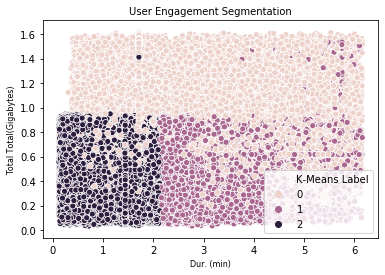

In [16]:
f, ax = plt.subplots()
sns.scatterplot(x ='Dur. (min)' ,y = 'Total Total(Gigabytes)', hue = 'K-Means Label', data=kseta, color="b")
ax.set_title('User Engagement Segmentation', fontsize=10)
ax.set_xlabel('Dur. (min)', fontsize=8)
ax.set_ylabel('Total Total(Gigabytes)', fontsize=8)
plt.show()

The minimum, maximum, average & total non- normalized metrics for
each cluster

In [17]:
kseta0 = kseta[kseta['K-Means Label'] == 0]
kseta1 = kseta[kseta['K-Means Label'] == 1]
kseta2 = kseta[kseta['K-Means Label'] == 2]

In [18]:
kseta0 = kseta0.append(['slice'], ignore_index=True)
kseta0 = kseta0.append(kseta0.min(), ignore_index=True)
kseta0 = kseta0.append(kseta0.max(), ignore_index=True)
kseta0 = kseta0.append(kseta0.mean(), ignore_index=True)
kseta0 = kseta0.append(kseta0.sum(), ignore_index=True)

kseta1 = kseta1.append(['slice'], ignore_index=True)
kseta1 = kseta1.append(kseta1.min(), ignore_index=True)
kseta1 = kseta1.append(kseta1.max(), ignore_index=True)
kseta1 = kseta1.append(kseta1.mean(), ignore_index=True)
kseta1 = kseta1.append(kseta1.sum(), ignore_index=True)

kseta2 = kseta2.append(['slice'], ignore_index=True)
kseta2 = kseta2.append(kseta2.min(), ignore_index=True)
kseta2 = kseta2.append(kseta2.max(), ignore_index=True)
kseta2 = kseta2.append(kseta2.mean(), ignore_index=True)
kseta2 = kseta2.append(kseta2.sum(), ignore_index=True)

In [19]:
#last 4
a0_plot = kseta0.iloc[-4:,1:]
a1_plot = kseta1.iloc[-4:,1:]
a2_plot = kseta2.iloc[-4:,1:]
plots = [a0_plot,a1_plot,a2_plot]

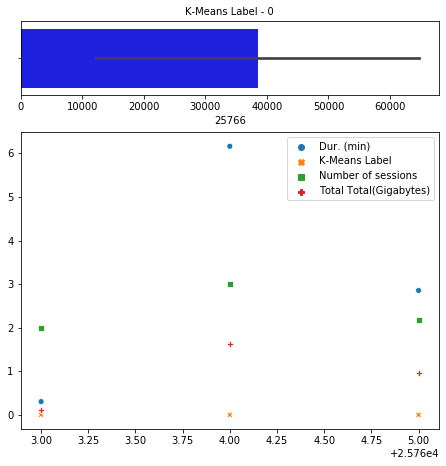

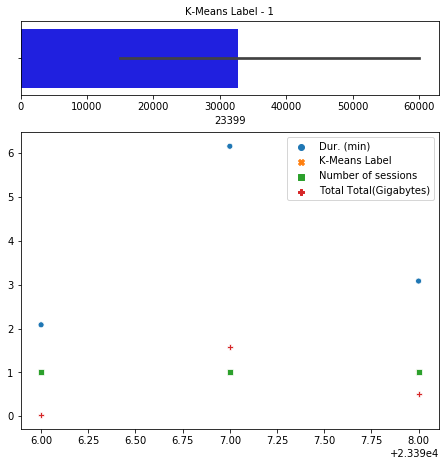

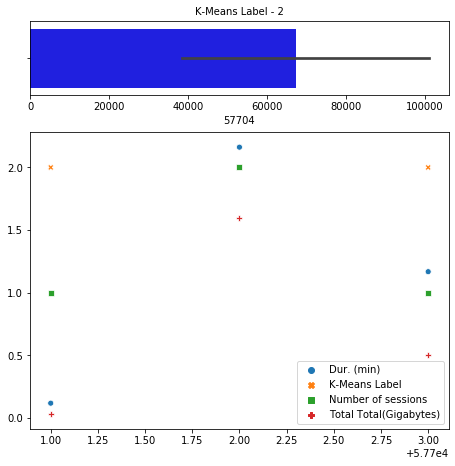

In [20]:
i = 0
for plot in plots:
    f, (ax_bar, ax_sca) = plt.subplots(2,figsize=(7.5,7.5),  gridspec_kw={"height_ratios": (.2, .8)})
    sns.barplot(plot.iloc[-1], ax=ax_bar,color="b")
    sns.scatterplot(data = plot.iloc[-4:-1],ax=ax_sca)
    ax_bar.set_title( plot.columns[1] + ' - ' +str(i) , fontsize=10)

    i = i + 1
    plt.show()

#### Set B

In [21]:
setb = data[['MSISDN/Number','Number of sessions','Dur. (min)','Total Apps(Gigabytes)']].copy()

In [22]:
#normalize
norm_setb = normalize(setb)

In [23]:
#initialization run 
kmeans.fit(norm_setb)
klabelsb = kmeans.labels_

In [24]:
#kmeans label to dataframe
blabels = pd.DataFrame(klabelsb,columns=['K-Means Label'])

In [25]:
#concat both original and labels
ksetbs = pd.concat([setb, blabels], axis=1)
ksetb = ksetbs.copy()
ksetb = ksetb.drop(['MSISDN/Number'], axis=1)

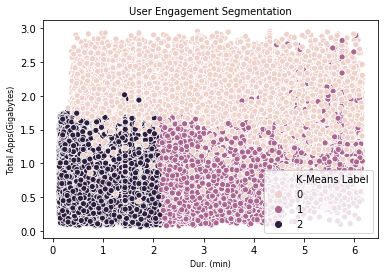

In [26]:
f, ax = plt.subplots()
sns.scatterplot(x ='Dur. (min)' ,y = 'Total Apps(Gigabytes)', hue = 'K-Means Label', data=ksetb, color="b")
ax.set_title('User Engagement Segmentation', fontsize=10)
ax.set_xlabel("Dur. (min)", fontsize=8)
ax.set_ylabel("Total Apps(Gigabytes)", fontsize=8)
plt.show()

The minimum, maximum, average & total non- normalized metrics for each cluster

In [27]:
ksetb0 = ksetb[ksetb['K-Means Label'] == 0]
ksetb1 = ksetb[ksetb['K-Means Label'] == 1]
ksetb2 = ksetb[ksetb['K-Means Label'] == 2]

In [28]:
ksetb0 = ksetb0.append(['slice'], ignore_index=True)
ksetb0 = ksetb0.append(ksetb0.min(), ignore_index=True)
ksetb0 = ksetb0.append(ksetb0.max(), ignore_index=True)
ksetb0 = ksetb0.append(ksetb0.mean(), ignore_index=True)
ksetb0 = ksetb0.append(ksetb0.sum(), ignore_index=True)

ksetb1 = ksetb1.append(['slice'], ignore_index=True)
ksetb1 = ksetb1.append(ksetb1.min(), ignore_index=True)
ksetb1 = ksetb1.append(ksetb1.max(), ignore_index=True)
ksetb1 = ksetb1.append(ksetb1.mean(), ignore_index=True)
ksetb1 = ksetb1.append(ksetb1.sum(), ignore_index=True)

ksetb2 = ksetb2.append(['slice'], ignore_index=True)
ksetb2 = ksetb2.append(ksetb2.min(), ignore_index=True)
ksetb2 = ksetb2.append(ksetb2.max(), ignore_index=True)
ksetb2 = ksetb2.append(ksetb2.mean(), ignore_index=True)
ksetb2 = ksetb2.append(ksetb2.sum(), ignore_index=True)

In [29]:
#last 4
b0_plot = ksetb0.iloc[-4:,1:]
b1_plot = ksetb1.iloc[-4:,1:]
b2_plot = ksetb2.iloc[-4:,1:]
plots = [b0_plot,b1_plot,b2_plot]

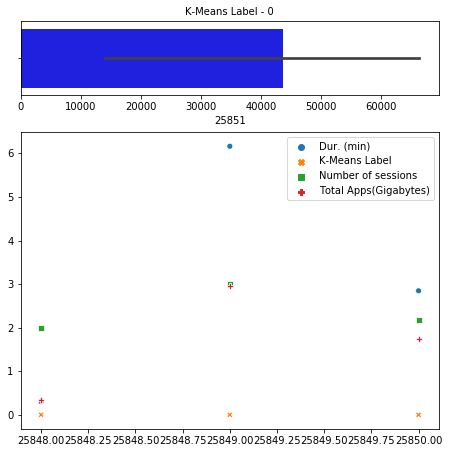

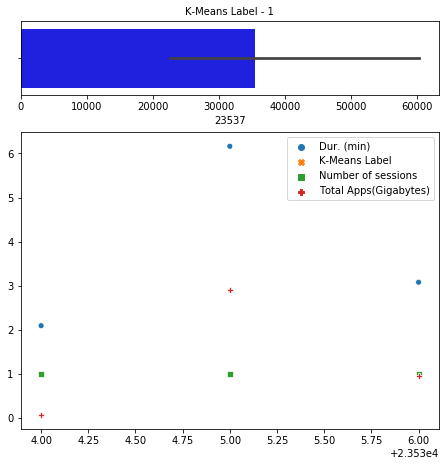

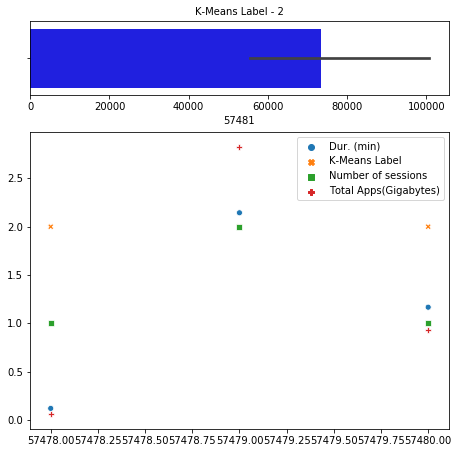

In [30]:
i = 0
for plot in plots:
    f, (ax_bar, ax_sca) = plt.subplots(2,figsize=(7.5,7.5),  gridspec_kw={"height_ratios": (.2, .8)})
    sns.barplot(plot.iloc[-1], ax=ax_bar,color="b")
    sns.scatterplot(data = plot.iloc[-4:-1],ax=ax_sca)
    ax_bar.set_title( plot.columns[1] + ' - ' +str(i) , fontsize=10)

    i = i + 1
    plt.show()

##### user total traffic per application

In [31]:
data = the_data[['MSISDN/Number','Social Media DL (Bytes)','Social Media UL (Bytes)','Google DL (Bytes)', 'Google UL (Bytes)', 'Email DL (Bytes)','Email UL (Bytes)', 'Youtube DL (Bytes)','Youtube UL (Bytes)','Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)','Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)']]

In [32]:
data['Social Media Total (Gigabytes)'] = (data['Social Media DL (Bytes)'] + data['Social Media UL (Bytes)'])/(1e+9)
data = data.drop(['Social Media DL (Bytes)', 'Social Media UL (Bytes)'], axis=1)

data['Google Total(Gigabytes)'] = (data['Google DL (Bytes)'] + data['Google UL (Bytes)'])/(1e+9)
data = data.drop(['Google DL (Bytes)', 'Google UL (Bytes)'], axis=1)

data['Email Total(Gigabytes)'] = (data['Email DL (Bytes)'] + data['Email UL (Bytes)'])/(1e+9)
data = data.drop(['Email DL (Bytes)', 'Email UL (Bytes)'], axis=1)

data['Youtube Total(Gigabytes)'] = (data['Youtube DL (Bytes)'] + data['Youtube UL (Bytes)'])/(1e+9)
data = data.drop(['Youtube DL (Bytes)', 'Youtube UL (Bytes)'], axis=1)

data['Netflix Total(Gigabytes)'] = (data['Netflix DL (Bytes)'] + data['Netflix UL (Bytes)'])/(1e+9)
data = data.drop(['Netflix DL (Bytes)', 'Netflix UL (Bytes)'], axis=1)

data['Gaming Total(Gigabytes)'] = (data['Gaming DL (Bytes)'] + data['Gaming UL (Bytes)'])/(1e+9)
data = data.drop(['Gaming DL (Bytes)', 'Gaming UL (Bytes)'], axis=1)

data['Other Total(Gigabytes)'] = (data['Other DL (Bytes)'] + data['Other UL (Bytes)'])/(1e+9)
data = data.drop(['Other DL (Bytes)', 'Other UL (Bytes)'], axis=1)


C:\Users\smwik\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### derive the top 10 most engaged users per application

In [33]:
ksetbs = pd.concat([data,blabels], axis=1)
tops = ksetbs.sort_values(by=['K-Means Label', 'Social Media Total (Gigabytes)'],ascending=False).iloc[0,0]
topg = ksetbs.sort_values(by=['K-Means Label', 'Google Total(Gigabytes)'],ascending=False).iloc[0,0]
tope = ksetbs.sort_values(by=['K-Means Label', 'Email Total(Gigabytes)'],ascending=False).iloc[0,0]
topy = ksetbs.sort_values(by=['K-Means Label', 'Youtube Total(Gigabytes)'],ascending=False).iloc[0,0]
topn = ksetbs.sort_values(by=['K-Means Label', 'Netflix Total(Gigabytes)'],ascending=False).iloc[0,0]
topg = ksetbs.sort_values(by=['K-Means Label', 'Gaming Total(Gigabytes)'],ascending=False).iloc[0,0]
topo = ksetbs.sort_values(by=['K-Means Label', 'Other Total(Gigabytes)'],ascending=False).iloc[0,0]


In [34]:
#top social met engaged user Social Media
tops

33632786471.0

In [35]:
#top social met engaged user google
topg

33663325062.0

In [36]:
#top social met engaged user email
tope

33668379944.0

In [37]:
#top social met engaged user youtube
topy

33658104203.0

In [38]:
#top social met engaged user netflix
topn

33698577660.0

In [39]:
#top social met engaged user games
topg

33663325062.0

In [40]:
#top social met engaged user other
topo

33761215277.0

#### top 3 most used applications

In [41]:
top_3apps = ksetbs.drop(['MSISDN/Number','K-Means Label'], axis=1).sum().sort_values(ascending=False).head(3)
top_3apps = pd.DataFrame(top_3apps)

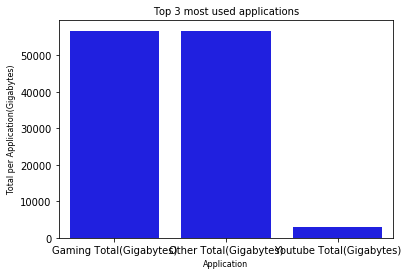

In [42]:
f, ax = plt.subplots()
sns.barplot(x=top_3apps.index, y=0, data=top_3apps, color="b")
ax.set_title('Top 3 most used applications', fontsize=10)
ax.set_xlabel("Application", fontsize=8)
ax.set_ylabel("Total per Application(Gigabytes)", fontsize=8)
plt.show()

##### k-means clustering algorithm

In [43]:
ksetbs1 = ksetbs.drop(['K-Means Label'], axis=1).copy()
norm_app = normalize(ksetbs1)

#initialization run 
kmeans.fit(norm_app)
label_app = kmeans.labels_

#kmeans label to dataframe
label_app = pd.DataFrame(label_app,columns=['K-Means Label Optimized'])

#concat both original and labels
ksetbs = pd.concat([ksetbs, label_app], axis=1)

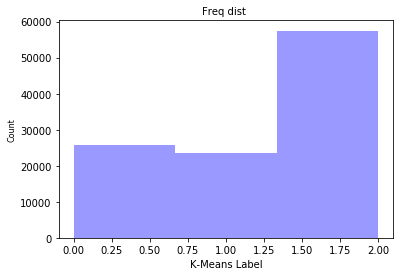

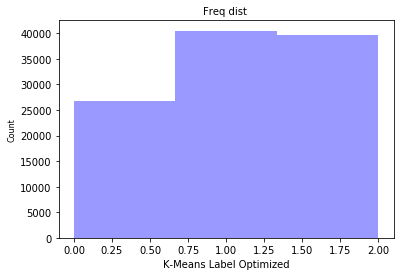

In [44]:
plot_list = [ksetbs.iloc[:,-2],ksetbs.iloc[:,-1]]
for x in plot_list:
    f, ax = plt.subplots()
    sns.distplot(x,color="b",kde=False, bins=3)
    ax.set_title('Freq dist ', fontsize=10)
    ax.set_ylabel('Count', fontsize=8)
    plt.show()

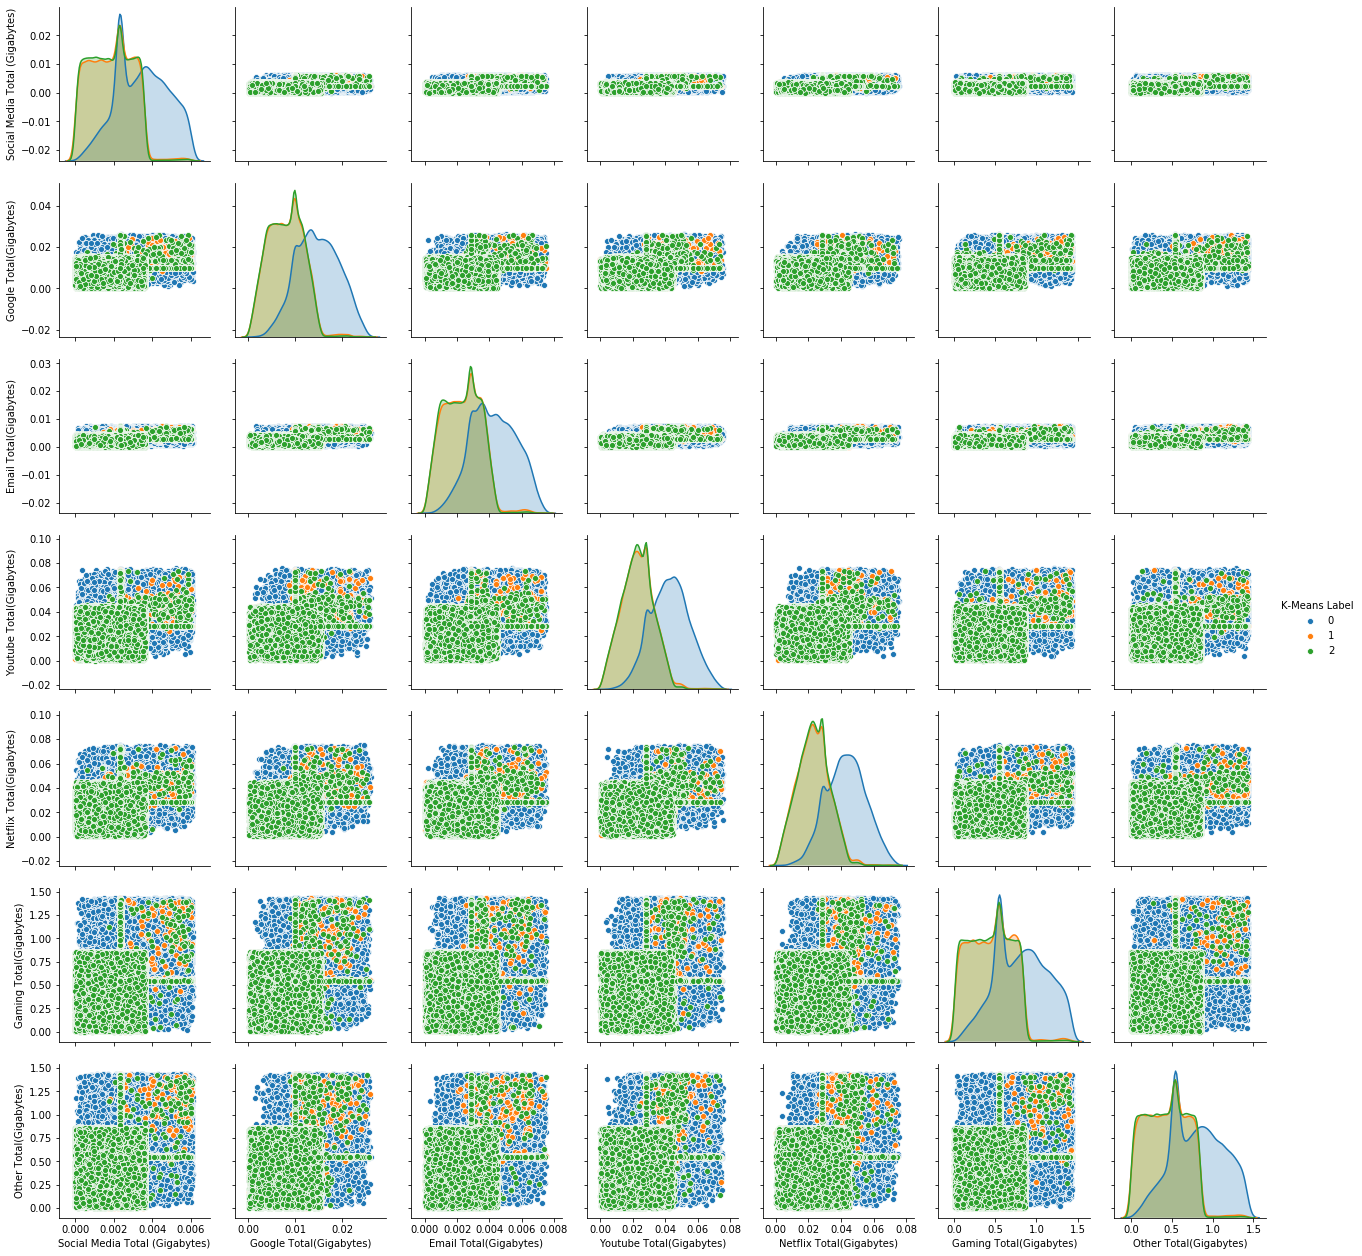

In [45]:
sns.pairplot(data=ksetbs.iloc[:,1:-1],hue = 'K-Means Label')
plt.show()

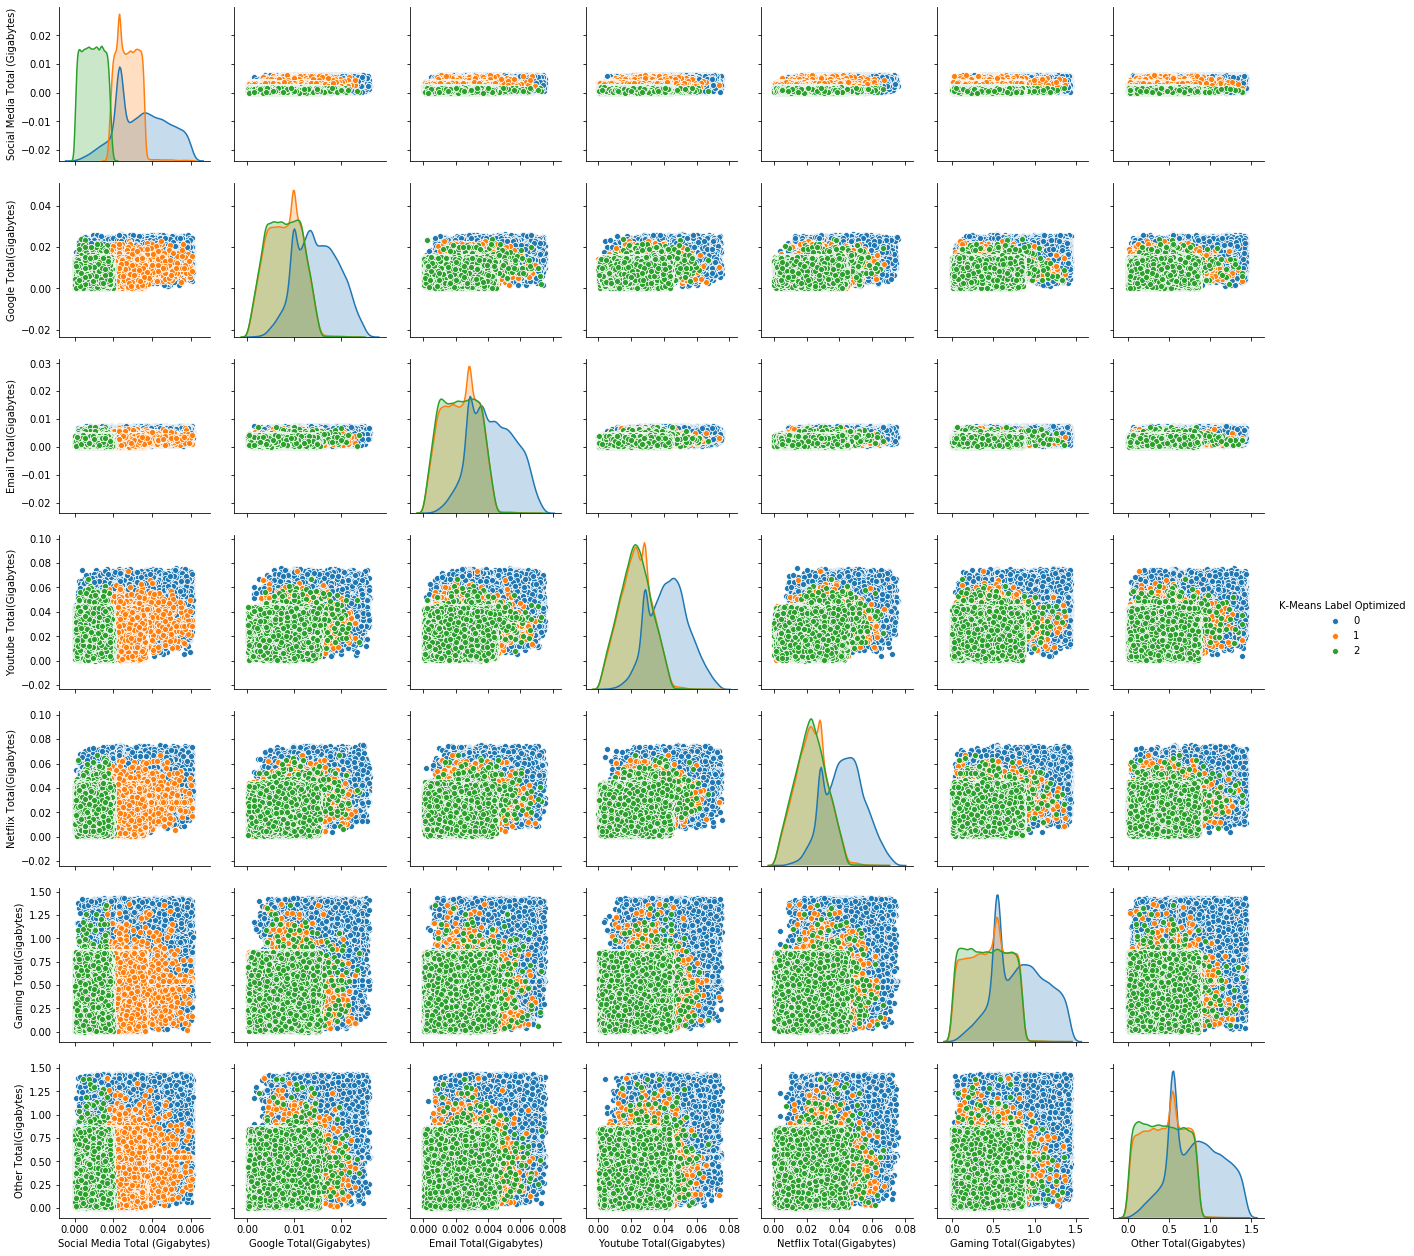

In [46]:
ksetbs = ksetbs.drop(['K-Means Label'], axis=1)
sns.pairplot(data=ksetbs.iloc[:,1:],hue = 'K-Means Label Optimized')
plt.show()

In [47]:
bset =setb.copy()

In [48]:
#function to normalize dataset
def spec_normalize(dataset):
    un_dataset = dataset.iloc[:,1:].values
    min_max_scaler = preprocessing.MinMaxScaler()
    dataset_scaled = min_max_scaler.fit_transform(un_dataset)
    n_dataset = pd.DataFrame(dataset_scaled,columns =[dataset.iloc[:,1:].columns] )
    n_dataset['MSISDN/Number'] = dataset['MSISDN/Number']
    return n_dataset

In [49]:
norm_set = spec_normalize(bset)

In [50]:
points = norm_set.drop('MSISDN/Number', axis=1)

kmeans = cluster.KMeans(n_clusters=3, random_state=0).fit(points)
norm_set['cluster'] = kmeans.labels_

centroids = kmeans.cluster_centers_
dists = pd.DataFrame(
    sdist.cdist(points, centroids), 
    columns=['dist_{}'.format(i) for i in range(len(centroids))],
    index=norm_setb.index)

x = pd.concat([norm_set,dists], axis=1, ignore_index=True)
x = x.rename(columns={0: "Number of sessions", 1: "Dur. (min)",2: "Total Apps(Gigabytes)", 3: "MSISDN/Number",4: "K-Means Label", 5: "dist_sessions",6: "dist_duration",7: "dist_total"})

C:\Users\smwik\Anaconda3\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [51]:
export = x[['MSISDN/Number','K-Means Label','dist_sessions','dist_duration','dist_total']]

In [52]:
export.to_csv('data/user_engagement.csv') 